In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import enum
import argparse
from datetime import datetime
import time

In [3]:
RESULTS_DIR = '../results/question_4_2_3/scheduler_2021-05-25T20-21-58Z'
QPS_INTERVAL_S = 10

In [4]:
os.environ['TZ'] = 'GMT'
time.tzset()

In [5]:
# Get the start timestamp from the raw latency file
start_ts = None

with open(os.path.join(RESULTS_DIR, 'latencies.raw')) as latfile:
    for line in latfile:
        
        if line.startswith('Timestamp start: '):
            start_ts = int(line[len('Timestamp start: '):])
            
if start_ts is None:
    print('Could not find start timestamp in raw latency file.')
    # return
    
print(start_ts)
    
# Read in the latencies
latencies = pd.read_csv(os.path.join(RESULTS_DIR, 'latencies.csv'))

# Annotate the latencies DF with the timestamps
latencies['Time'] = (latencies.index + 1) * QPS_INTERVAL_S

1621974121448


In [51]:
# Read in the scheduler log
with open(os.path.join(RESULTS_DIR, 'scheduler.log')) as logfile:
    log = logfile.readlines()

# Parse memcached cores into DataFrame
memcached_cores = pd.DataFrame(columns=['Time', 'Cores'])

# Parse a list of time pairs for each job
bm_intervals = {}
bm_open = {}

# Add start memcached_cores to 0 to account for slight timestamp discrepancies
curr_cores = 1
memcached_cores = memcached_cores.append({'Time': 0, 'Cores': 1}, ignore_index=True)

for line in log:
    line = line[:-1]
    # Split timestamp and event
    datestr = line[:19]
    event_desc = line[20:]
    
    # Get the POSIX timestamp
    ts = int(datetime.strptime(datestr, '%Y/%m/%d %H:%M:%S').timestamp())
    rel_time = int(ts - (start_ts / 1000.))

    # Determine type of event
    if event_desc.startswith('memcached running on cpu '):
        # Memcached core allocation change
        memcached_cores = memcached_cores.append({'Time': rel_time, 'Cores': curr_cores}, ignore_index=True)
        cores = int(((len(event_desc) -  len('memcached running on cpu ') + 1)) / 2)
        memcached_cores = memcached_cores.append({'Time': rel_time, 'Cores': cores}, ignore_index=True)
        curr_cores = cores
        
    elif event_desc.startswith('Started job '):
        # Benchmark starting, open interval
        bm_open[event_desc[len('Started job '):]] = rel_time
        
    elif event_desc.startswith('Unpaused job '):
        # Benchmark unpausing, open interval
        bm_open[event_desc[len('Unpaused job '):]] = rel_time
        
    elif event_desc.startswith('Completed job ') or event_desc.startswith('Paused job '):
        prefix = 'Completed job ' if event_desc.startswith('Completed job ') else 'Paused job '
        
        # Benchmark ending or pausing, close and append interval
        job_name = event_desc[len(prefix):]
        
        if job_name not in bm_intervals:
            bm_intervals[job_name] = []
        
        bm_intervals[job_name].append((bm_open[job_name], rel_time - bm_open[job_name]))

# Get the finish time of the scheduler end
end_time = bm_events.iloc[len(bm_events) - 1].Time
end_time += end_time % QPS_INTERVAL_S

# Trim all latency data to the 'end' of the scheduler
latencies = latencies[latencies['Time'] <= end_time]

# Add finisher to memcached_cores to finish curve
memcached_cores = memcached_cores.append({'Time': end_time, 'Cores': curr_cores}, ignore_index=True)

In [64]:
print(sns.color_palette().as_hex())
sns.color_palette()

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']


[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

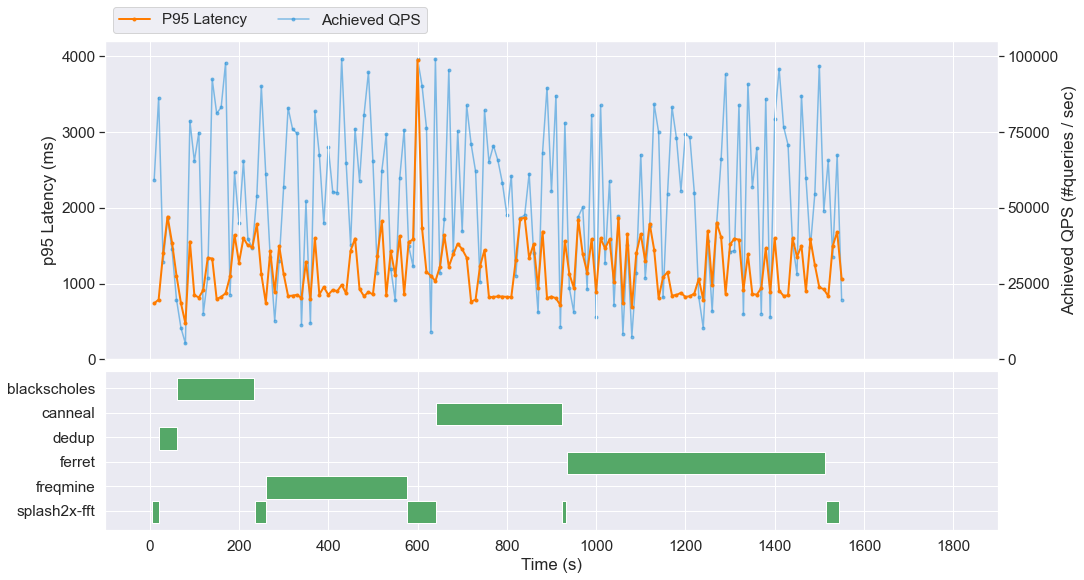

In [85]:
# Plot A
sns.set(style='darkgrid', font_scale=1.4)
figure, (ax1, ax_annot) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16,9), gridspec_kw={'height_ratios': [2, 1]})
plt.subplots_adjust(wspace=0, hspace=0.05)

# Plot the main plot A component in the first subplot
ax2 = ax1.twinx()
p95 = ax1.plot(latencies['Time'], latencies['p95'], marker='o', markersize=3, color='#ff7c00', label='P95 Latency', linewidth=2)
qps = ax2.plot(latencies['Time'], latencies['QPS'], marker='o', markersize=3, color='#3498db', label='Achieved QPS', alpha=0.6)

# Order so latency appears on top
ax1.set_zorder(2)
ax1.patch.set_visible(False)
ax1.yaxis.grid(False)
ax2.patch.set_visible(True)

# Add legend
lines = p95 + qps
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, bbox_to_anchor=(0, 1, 1, 0), loc="lower left", ncol=2)

# Axis ordering and alignment
plt.xlim([-100, 1900])
plt.xticks(range(0, 1801, 200))

ax1.set_yticks(range(0, 4001, 1000))
ax1.set_ylim([0, 4201])
ax2.set_yticks(range(0, 100001, 25000))
ax2.set_ylim([0, 105001])

# Labels
ax2.set_ylabel('Achieved QPS (#queries / sec)')
ax1.set_ylabel('p95 Latency (ms)')

# Plot the bottom task annotations
bar_w = 4
for i, (job, intervals) in enumerate(sorted(list(bm_intervals.items()), key=lambda x: x[0], reverse=True)):
    ax_annot.broken_barh(intervals, (bar_w * (i + 1), bar_w - 0.4), facecolors='#55a868')
    
ax_annot.set_yticks([(3 * bar_w / 2) + bar_w * j for j in range(len(bm_intervals))])
ax_annot.set_yticklabels(sorted(list(bm_intervals.keys()), reverse=True))
ax_annot.set_xlabel('Time (s)')

# Save
plt.savefig(os.path.join(RESULTS_DIR, 'plot_a.png'))

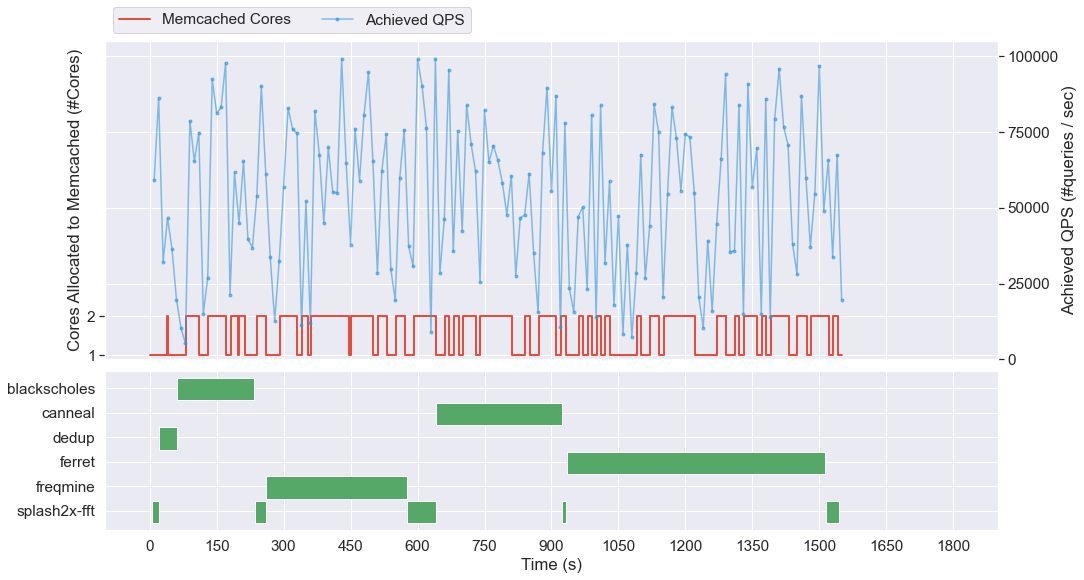

In [86]:
# Plot B
sns.set(style='darkgrid', font_scale=1.4)
figure, (ax1, ax_annot) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16,9), gridspec_kw={'height_ratios': [2, 1]})
plt.subplots_adjust(wspace=0, hspace=0.05)

ax2 = ax1.twinx()
cores = ax1.plot(memcached_cores['Time'], memcached_cores['Cores'], color='#e74c3c', label='Memcached Cores', linewidth=2)
qps = ax2.plot(latencies['Time'], latencies['QPS'], marker='o', markersize=3, color='#3498db', label='Achieved QPS', alpha=0.6)

lines = cores + qps
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, bbox_to_anchor=(0, 1, 1, 0), loc="lower left", ncol=2)

plt.xlim([-100, 1900])
plt.xticks(range(0, 1801, 150))

ax1.set_yticks([1, 2])
ax1.set_ylim([0.9, 9])
ax2.set_yticks(range(0, 100001, 25000))
ax2.set_ylim([0, 105001])

ax2.set_ylabel('Achieved QPS (#queries / sec)')
ax1.set_ylabel('Cores Allocated to Memcached (#Cores)')

# Plot the bottom task annotations
bar_w = 4
for i, (job, intervals) in enumerate(sorted(list(bm_intervals.items()), key=lambda x: x[0], reverse=True)):
    ax_annot.broken_barh(intervals, (bar_w * (i + 1), bar_w - 0.4), facecolors='#55a868')
    
ax_annot.set_yticks([(3 * bar_w / 2) + bar_w * j for j in range(len(bm_intervals))])
ax_annot.set_yticklabels(sorted(list(bm_intervals.keys()), reverse=True))
ax_annot.set_xlabel('Time (s)')

plt.savefig(os.path.join(RESULTS_DIR, 'plot_b.png'))